# Filter study for Cryoscope

The goal of this notebook was to found a code to solve the problem of causal dependence in the savgol filter

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal

from pathlib import Path
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.signal import lfilter

from qibocal.protocols.two_qubit_interaction.cryoscope import _plot, CryoscopeData, CryoscopeResults, CryoscopeType 
from qibocal.protocols.ramsey.utils import fitting


FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(50), np.zeros(10)])


[Qibo 0.2.12|INFO|2024-11-29 17:28:38]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-11-29 17:28:38]: Loading platform dummy


In [2]:
def _fit(data: CryoscopeData, savgol: bool, demod: bool) -> CryoscopeResults:

    nyquist_order = 0

    fitted_parameters = {}
    detuning = {}
    amplitude = {}
    step_response = {}
    for qubit, setup in data.data:
        qubit_data = data[qubit, setup]
        x = qubit_data.duration
        y = 1 - 2 * qubit_data.prob_1

        popt, _ = fitting(x, y)

        fitted_parameters[qubit, setup] = popt

    qubits = np.unique([i[0] for i in data.data]).tolist()

    for qubit in qubits:

        sampling_rate = 1 / (x[1] - x[0])
        X_exp = 1 - 2 * data[(qubit, "MX")].prob_1
        Y_exp = 1 - 2 * data[(qubit, "MY")].prob_1

        norm_data = X_exp + 1j * Y_exp

        # demodulation frequency found by fitting sinusoidal
        demod_freq = -fitted_parameters[qubit, "MY"][2] / 2 / np.pi * sampling_rate

        # to be used in savgol_filter
        derivative_window_length = 7 / sampling_rate
        derivative_window_size = max(3, int(derivative_window_length * sampling_rate))
        derivative_window_size += (derivative_window_size + 1) % 2

        # find demodulatation frequency
        if demod:
            demod_data = np.exp(2 * np.pi * 1j * x * demod_freq) * (norm_data)
        else:
            demod_data = norm_data
            
        # compute phase
        phase = np.unwrap(np.angle(demod_data))

        # compute detuning

        if savgol:
            phase = causal_savgol_filter(
                phase / (2 * np.pi),
                window_length=derivative_window_size,
                polyorder=2,
                deriv = 1,
                )
            raw_detuning = (phase * sampling_rate
            )
        else:
            phase = phase/(2*np.pi)
            raw_detuning = (phase*sampling_rate)

        # real detuning (reintroducing demod_freq)
        detuning[qubit] = (
            raw_detuning - demod_freq + sampling_rate * nyquist_order
        ).tolist()

        # params from flux_amplitude_frequency_protocol
        params = [1.9412681243469971, -0.012534948170662627, 0.0005454772278201887]

        # invert frequency amplitude formula
        p = np.poly1d(params)
        amplitude[qubit] = [max((p - freq).roots).real for freq in detuning[qubit]]

        # compute step response
        step_response[qubit] = (
            np.array(amplitude[qubit]) / data.flux_pulse_amplitude
        ).tolist()

    return CryoscopeResults(
        amplitude=amplitude,
        detuning=detuning,
        step_response=step_response,
        fitted_parameters=fitted_parameters,
    ), raw_detuning, phase

**Loading data**

In [3]:
def load_cryoscope_data(file_path: str, flux_pulse_amplitude: float) -> CryoscopeData:

    cryoscope_data = CryoscopeData(flux_pulse_amplitude = flux_pulse_amplitude)
    
    data_npz = np.load(file_path)
    D1MX = np.rec.array(data_npz['["D1", "MX"]'])
    D1MY = np.rec.array(data_npz['["D1", "MY"]'])
    
    data_dict = {
        ("D1", "MX") : D1MX,
        ("D1", "MY") : D1MY
    }

    cryoscope_data.data = data_dict

    return cryoscope_data


In [4]:
# Load data
data_path = Path.cwd().parent / "cryo_material" / "cryoscope" / "data" / "cryoscope-0"
results_json = data_path / "results.json"
data_json = data_path / "data.json"

with open(data_json, "r") as file:
    data = json.load(file)

with open(results_json, "r") as file:
    results = json.load(file)

print(data)
print(results)

{'"flux_pulse_amplitude"': 0.1}
{'"fitted_parameters"': {'["D1", "MX"]': [-0.00029639988763097147, 0.9259233868264589, 0.11297702572931177, 0.6811588111300295, 0.000200444727454511], '["D1", "MY"]': [-0.04330729231685593, 0.8053304242090724, 0.10001152244951339, -0.4561057364051088, 2.2940053954883843e-20]}, '"detuning"': {'"D1"': [0.0009089261001269961, 0.000771851252188812, 0.0006347764042506296, 0.0004977015563124541, 0.0006846099963171426, 0.0013814410767795885, 0.0009524330694135, 0.0020828945176104875, 0.00451965116963066, 0.008056748847200531, 0.010930627775662245, 0.01474036564921474, 0.01760471010827338, 0.018092453186971134, 0.018848063875241225, 0.019652778635600485, 0.020640357880029162, 0.020271250427942165, 0.020203698291166236, 0.020596376668128507, 0.020954302520328046, 0.021055945473469714, 0.020656135007137394, 0.019722949412587443, 0.018482234744427915, 0.017193251219308283, 0.016571813635514302, 0.01759950666098585, 0.018236536283483897, 0.0190546229767291, 0.019108

In [20]:
flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", flux_pulse_amplitude)

### Changing savgol filter values

In [21]:
#applicazione del filtro sui dati demodulati vs non demodulati
_, _, savgol_demod = _fit(cryoscope_data, True, True)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False)

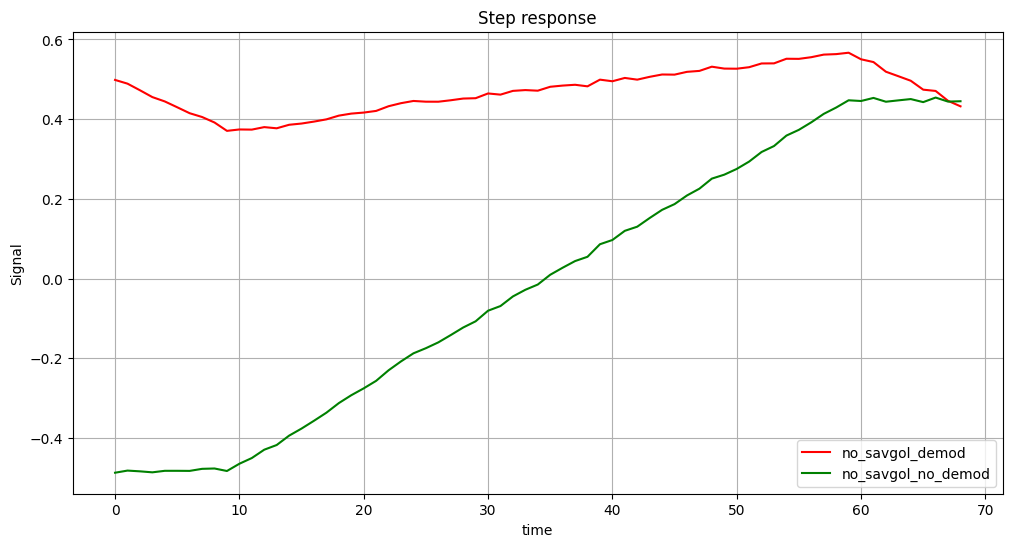

In [22]:
plt.figure(figsize=(12, 6)) 
plt.plot(no_savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(no_savgol_no_demod, color = "green", label="no_savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

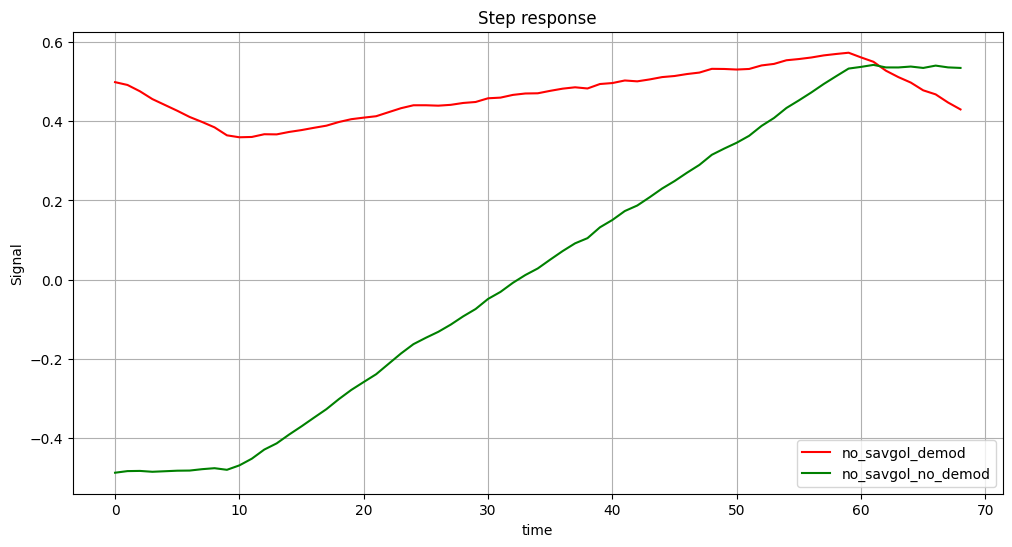

In [23]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(savgol_no_demod, color = "green", label="no_savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [31]:
#applicazione del filtro sui dati demodulati vs non demodulati, nearest, window length 7
_, _, savgol_demod = _fit(cryoscope_data, True, True)
_, _, savgol_no_demod = _fit(cryoscope_data, True, False)
_, _, no_savgol_demod = _fit(cryoscope_data, False, True)
_, _, no_savgol_no_demod = _fit(cryoscope_data, False, False)

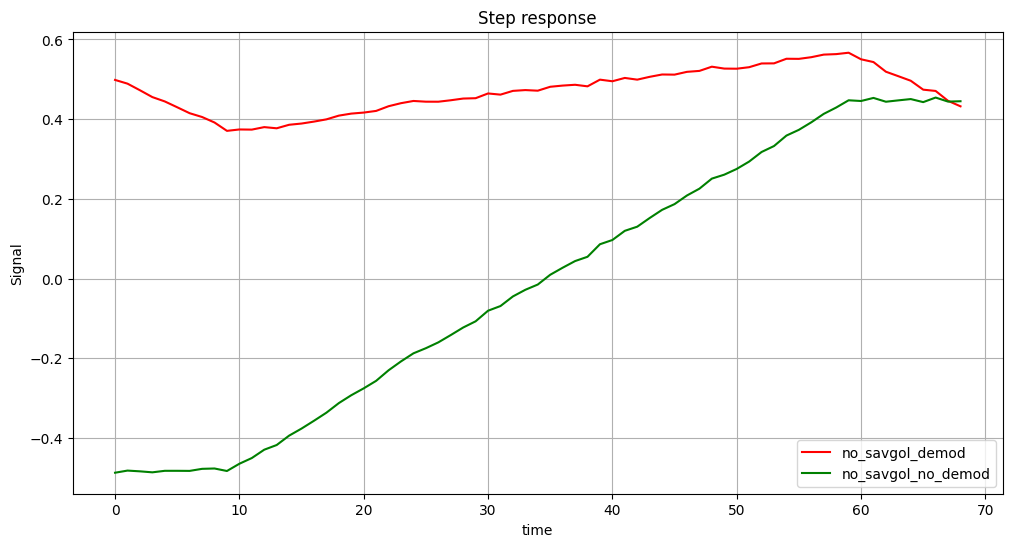

In [32]:
plt.figure(figsize=(12, 6)) 
plt.plot(no_savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(no_savgol_no_demod, color = "green", label="no_savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

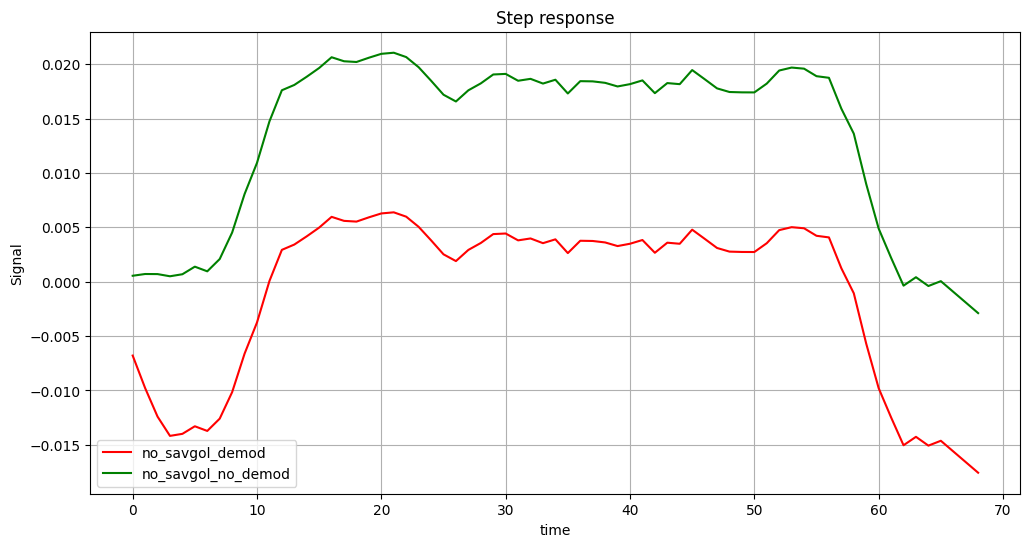

In [33]:
plt.figure(figsize=(12, 6)) 
plt.plot(savgol_demod, color = "red", label="no_savgol_demod")
plt.plot(savgol_no_demod, color = "green", label="no_savgol_no_demod")
#plt.plot(FULL_WAVEFORM, color = "blue", label="rectangular pulse")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

### Useless stuf

In [ ]:
def causal_savgol_filter(x, window_length, polyorder, deriv):
    # Ensure window length is odd
    if window_length % 2 == 0:
        window_length += 1
    
    # Create a modified filter using only past data points
    # Reduce the window so it only looks backward
    causal_window = window_length // 2 * 2 + 1
    
    # Create a custom window that only uses past points
    filtered = np.zeros_like(x)
    
    for i in range(len(x)):
        # Determine the start of the window
        start = max(0, i - causal_window // 2)
        
        # Extract the causal window
        window = x[start:i+1]
        
        # If the window is too small, pad with the first value
        if len(window) < causal_window:
            window = np.pad(window, (causal_window - len(window), 0), 
                            mode='constant', constant_values=x[0])
        
        # Apply Savitzky-Golay filter to this causal window
        filtered[i] = scipy.signal.savgol_filter(window, window_length=causal_window, 
                                    polyorder=polyorder, deriv)[-1]
    
    return filtered